# Predicción de Consumo Energético en la Industria del Acero

# **Analisis de Requerimientos**

### OBJETIVO

**Proposición de valor**:
Desarrollar un sistema predictivo que estime el consumo energético de una planta siderúrgica en intervalos de 15 minutos, con el fin de optimizar el uso de energía eléctrica, reducir costos operativos y mejorar la sostenibilidad ambiental.

**¿Por qué es importante?**

El sector industrial es uno de los mayores consumidores de energía, por lo que el poder anticipar la demanda permite implementar estrategias de ahorro (tarifas horarias, apagado de cargas no críticas, mantenimiento preventivo) permitiendo reducir picos de consumo y penalizaciones por exceso de demanda.

**¿Quién lo va a usar?**

- Ingenieros de operaciones y mantenimiento.
- Personal de planeación energética.
- Analistas de sostenibilidad.
- Sistemas automáticos de gestión de energía (EMS).

### APRENDER

**Fuentes de datos**:

- Dataset público de UCI Machine Learning Repository: Steel Industry Energy Consumption Dataset.
- Sensores de consumo eléctrico y variables operativas de una planta siderúrgica (potencia activa, reactiva, CO₂, tipo de carga, etc.).

**Recolección de datos**:

- Datos registrados automáticamente cada 15 minutos en los sistemas SCADA o PLC de la planta.
- Datos históricos para entrenamiento (año 2021–2022).
- Nuevos datos obtenidos de sensores en tiempo real para reentrenamiento periódico.

**Características**:

- **Entrada**:

    * Potencia reactiva con desfase (lagging/leading kVarh).
    * Factor de potencia (lagging/leading).
    * Emisiones de CO₂.
    * Día de la semana y hora del día.
    * Tipo de carga (ligera, media, máxima).
    * Estado de la semana (fin de semana o laboral).
    * Segundos desde medianoche (timestamp).

- **Salida**:

    * Consumo energético (Usage_kWh).

**Construcción de modelos**:

- Retraining semanal o mensual (según frecuencia de drift detectado).
- Uso de pipelines de entrenamiento reproducibles con DVC y MLflow.
- Tiempo disponible para entrenamiento: < 10 minutos (modelo liviano, actualizable).

### PREDECIR

**Tarea de Machine Learning (ML Task)**:

- Tipo: **Regresión supervisada.**
- Entrada: **variables operativas y temporales.**
- Salida: **predicción del consumo de energía (kWh).**
- Algoritmos candidatos:
    * Modelos baseline (Regresión Lineal).
    * Random Forest, XGBoost, CatBoost.
    * Modelos de series temporales simples (ARIMA, Prophet) para comparación.

**Decisiones**:

- Las predicciones alimentarán un panel de control de consumo energético.
- Si se prevé un pico de consumo, el sistema recomendará reducción o cambio de carga.
- Se generarán alertas cuando se exceda el umbral esperado.

**Hacer predicciones**:

- En tiempo real o por lotes cada 15 minutos.
- API REST desarrollada con FastAPI, consumida por dashboards o sistemas SCADA.

**Evaluación offline**:

- Dividir dataset en entrenamiento (70%), validación (15%) y prueba (15%).
- Métricas:
    * **RMSE, MAE, MAPE, R².**
- Validación temporal para evitar data leakage.
- Registro automático de experimentos con MLflow.

### EVALUAR

**Monitorización y evaluación en vivo**:

- Integración de Evidently AI para monitorear:
    * Data drift (cambio en distribución de variables).
    * Concept drift (degradación del rendimiento).
    * Métricas de precisión y errores recientes.
- Retraining automático si el error promedio supera el umbral de 15%.
- Reportes semanales de desempeño y alertas automáticas a través de dashboard o correo.

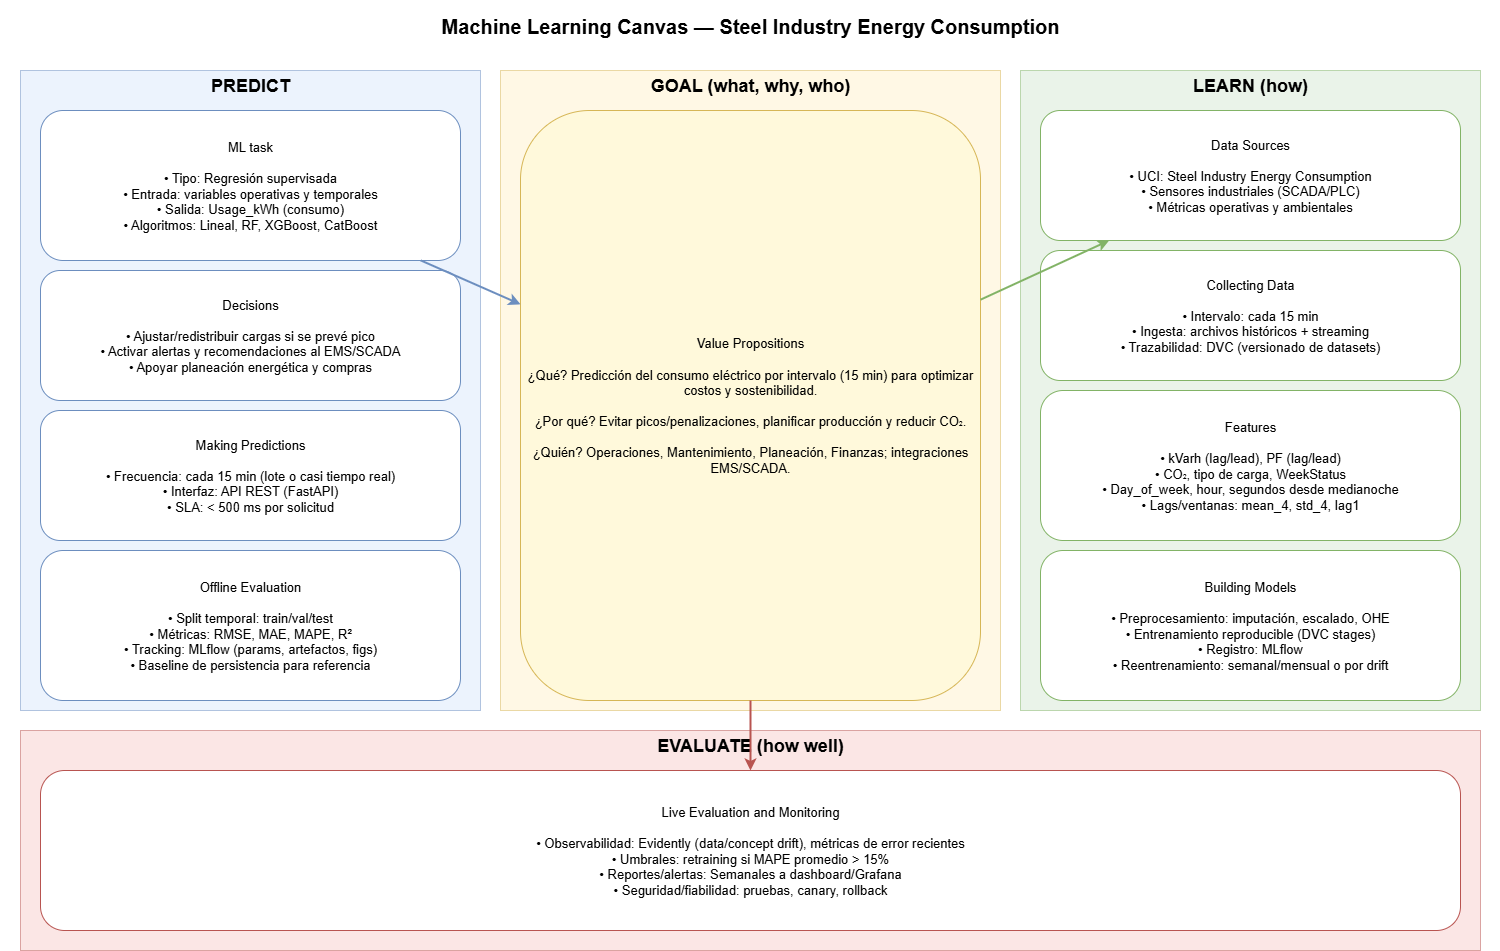

# **Manipulación y preparación de datos**

#### Carga de datos

In [1]:
# Libreria a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from utils import limpiar_columna_numerica, detectar_strings_en_columna, detectar_strings_fecha, limpiar_columna_fecha
#from eda_utils import load_steel_dataset, coerce_mixed_types_for_steel

In [2]:
# Leemos el Dataset
#df = pd.read_csv('steel_energy_modified.csv', low_memory=False, dtype={'date': str, 'Usage_kWh': str, 'Lagging_Current_Reactive.Power_kVarh': str, 'Leading_Current_Reactive_Power_kVarh': str, 'CO2(tCO2)': str, 'Lagging_Current_Power_Factor': str, 'Leading_Current_Power_Factor': str, 'NSM': str, 'WeekStatus': str, 'Day_of_week': str, 'Load_Type': str, 'mixed_type_col': str})
df = pd.read_csv('steel_energy_modified.csv', low_memory=False)
#df, tipo_report = load_steel_dataset('steel_energy_modified.csv', arrow_backend=False)
print("Dataset cargado correctamente")

Dataset cargado correctamente


#### Exploratory Data Analysis (EDA)

In [3]:
# Número de filas y columnas
df.shape

(35740, 12)

In [4]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.0,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.5,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


In [5]:
# Tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35740 entries, 0 to 35739
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   date                                  35401 non-null  object
 1   Usage_kWh                             35339 non-null  object
 2   Lagging_Current_Reactive.Power_kVarh  35339 non-null  object
 3   Leading_Current_Reactive_Power_kVarh  35327 non-null  object
 4   CO2(tCO2)                             35370 non-null  object
 5   Lagging_Current_Power_Factor          35291 non-null  object
 6   Leading_Current_Power_Factor          35338 non-null  object
 7   NSM                                   35325 non-null  object
 8   WeekStatus                            35400 non-null  object
 9   Day_of_week                           35428 non-null  object
 10  Load_Type                             35432 non-null  object
 11  mixed_type_col              

In [6]:
# Estadísticas descriptivas
df.describe(include='all').T

,count,unique,top,freq
date,35401,34753,NAN,23
Usage_kWh,35339,4410,3.06,605
Lagging_Current_Reactive.Power_kVarh,35339,2918,0.0,6866
Leading_Current_Reactive_Power_kVarh,35327,1336,0.0,22358
CO2(tCO2),35370,249,0.0,20009
Lagging_Current_Power_Factor,35291,6478,100.0,7082
Leading_Current_Power_Factor,35338,3968,100.0,23037
NSM,35325,517,52200.0,357
WeekStatus,35400,5,Weekday,24048
Day_of_week,35428,15,Monday,4876


#### Pre-Limpieza de datos

Vemos que los datos no corresponden en tipo, revisando se encuentra que en todas las columnas numericas adicional a que puede haber valores faltantes o nulos hay valores de cadena (error, invalid). Por lo que para asignar valores correctos debemos limpiar los datos, esto tambien es importante para la visualización de dato.

In [7]:
columnas = ['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','NSM','mixed_type_col']
valores_invalidos_global = set()
for t in columnas:
    valores_texto = detectar_strings_en_columna(df, t)
    if len(valores_texto) > 0:
        valores_invalidos_global.update(valores_texto)
        df = limpiar_columna_numerica(df, t, valores_texto)

print('\n\nValores string identificados')
valores_invalidos_global

Se encontraron 6 valores no numéricos en 'Usage_kWh':
['error', 'invalid', 'n/a', '?', 'ERROR', 'INVALID']
Se encontraron 90 valores no numéricos en 'Usage_kWh' que serán reemplazados por NaN.
La columna 'Usage_kWh' ahora es de tipo: float64
Se encontraron 6 valores no numéricos en 'Lagging_Current_Reactive.Power_kVarh':
['invalid', '?', 'error', 'ERROR', 'n/a', 'INVALID']
Se encontraron 109 valores no numéricos en 'Lagging_Current_Reactive.Power_kVarh' que serán reemplazados por NaN.
La columna 'Lagging_Current_Reactive.Power_kVarh' ahora es de tipo: float64
Se encontraron 6 valores no numéricos en 'Leading_Current_Reactive_Power_kVarh':
['ERROR', 'error', 'invalid', 'INVALID', '?', 'n/a']
Se encontraron 119 valores no numéricos en 'Leading_Current_Reactive_Power_kVarh' que serán reemplazados por NaN.
La columna 'Leading_Current_Reactive_Power_kVarh' ahora es de tipo: float64
Se encontraron 6 valores no numéricos en 'CO2(tCO2)':
['invalid', '?', 'INVALID', 'error', 'ERROR', 'n/a']
Se 

{'?', 'ERROR', 'INVALID', 'bad', 'error', 'invalid', 'n/a', 'unknown'}

In [8]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649.0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696.0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630.0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325.0


In [9]:
df = limpiar_columna_fecha(
    df,
    'date',
    formato_base="%d/%m/%Y %H:%M",
    aceptar_segundos=True,
    valores_invalidos=detectar_strings_fecha(
    df,
    'date',
    formato_base="%d/%m/%Y %H:%M",  # dd/mm/YYYY HH:MM
    aceptar_segundos=True            # acepta también dd/mm/YYYY HH:MM:SS
)
)

Todos los valores en 'date' cumplen el/los formato(s) indicado(s).
'date' → datetime64[ns]. Parseadas: 35378, NaT: 362.


In [10]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:15:00,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649.0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696.0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630.0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325.0


In [11]:
# Tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35740 entries, 0 to 35739
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35378 non-null  datetime64[ns]
 1   Usage_kWh                             35224 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35210 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35186 non-null  float64       
 4   CO2(tCO2)                             35230 non-null  float64       
 5   Lagging_Current_Power_Factor          35168 non-null  float64       
 6   Leading_Current_Power_Factor          35214 non-null  float64       
 7   NSM                                   35185 non-null  float64       
 8   WeekStatus                            35400 non-null  object        
 9   Day_of_week                           35428 non-null  object        
 10

In [12]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:15:00,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649.0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696.0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630.0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325.0


In [13]:
# Estadísticas descriptivas
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,35378,NaN,NaN,NaN,2018-07-02 14:56:25.595567872,2018-01-01 00:00:00,2018-04-02 06:48:45,2018-07-02 14:52:30,2018-10-01 21:26:15,2018-12-31 23:45:00,NaN
Usage_kWh,35224.0,NaN,NaN,NaN,39.400143,0.0,3.24,4.61,52.06,34899.48,276.516063
Lagging_Current_Reactive.Power_kVarh,35210.0,NaN,NaN,NaN,18.734507,0.0,2.3,5.0,23.33,6145.92,89.876721
Leading_Current_Reactive_Power_kVarh,35186.0,NaN,NaN,NaN,7.617218,0.0,0.0,0.0,2.59,2301.84,55.10866
CO2(tCO2),35230.0,NaN,NaN,NaN,2.635854,0.0,0.0,0.0,0.02,1364.04,41.636508
Lagging_Current_Power_Factor,35168.0,NaN,NaN,NaN,101.634809,0.0,63.55,88.21,99.46,9900.0,316.378288
Leading_Current_Power_Factor,35214.0,NaN,NaN,NaN,109.390282,0.0,99.7225,100.0,100.0,9800.0,371.783664
NSM,35185.0,NaN,NaN,NaN,52646.198664,0.0,21600.0,43200.0,64800.0,7783200.0,192885.357686
WeekStatus,35400,5,Weekday,24048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day_of_week,35428,15,Monday,4876,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Después de revisar las cadenas que existen en las columnas numericas ('?', 'ERROR', 'INVALID', 'bad', 'error', 'invalid', 'n/a', 'unknown'), se determina que pueden ser colocadas como NaN para ser inputadas mas adelante. Con esto se puede definir el tipo de columnas para una visualizacion inicial.

In [14]:
# Valores nulos
df.isnull().sum()

date                                      362
Usage_kWh                                 516
Lagging_Current_Reactive.Power_kVarh      530
Leading_Current_Reactive_Power_kVarh      554
CO2(tCO2)                                 510
Lagging_Current_Power_Factor              572
Leading_Current_Power_Factor              526
NSM                                       555
WeekStatus                                340
Day_of_week                               312
Load_Type                                 308
mixed_type_col                          10644
dtype: int64

In [15]:
# Duplicados
print("Registros duplicados:", df.duplicated().sum())

Registros duplicados: 30


#### Visualización de datos

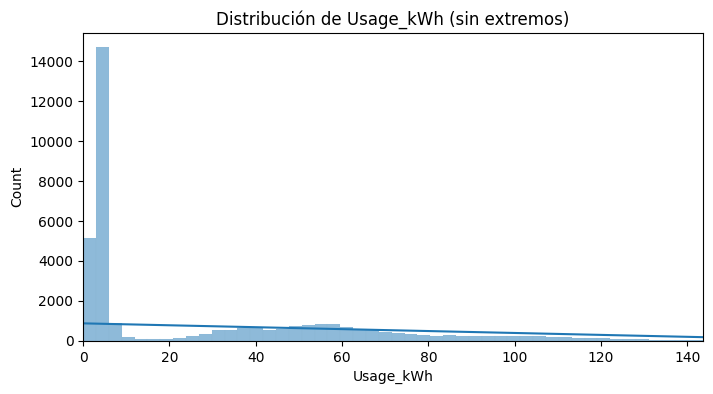

In [16]:
# Distribución de la variable objetivo
plt.figure(figsize=(8,4))
sns.histplot(df["Usage_kWh"], kde=True)
plt.xlim(0, df["Usage_kWh"].quantile(0.99))  # muestra hasta el percentil 99
plt.title('Distribución de Usage_kWh (sin extremos)')
plt.show()

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'mixed_type_col'],
      dtype='object')


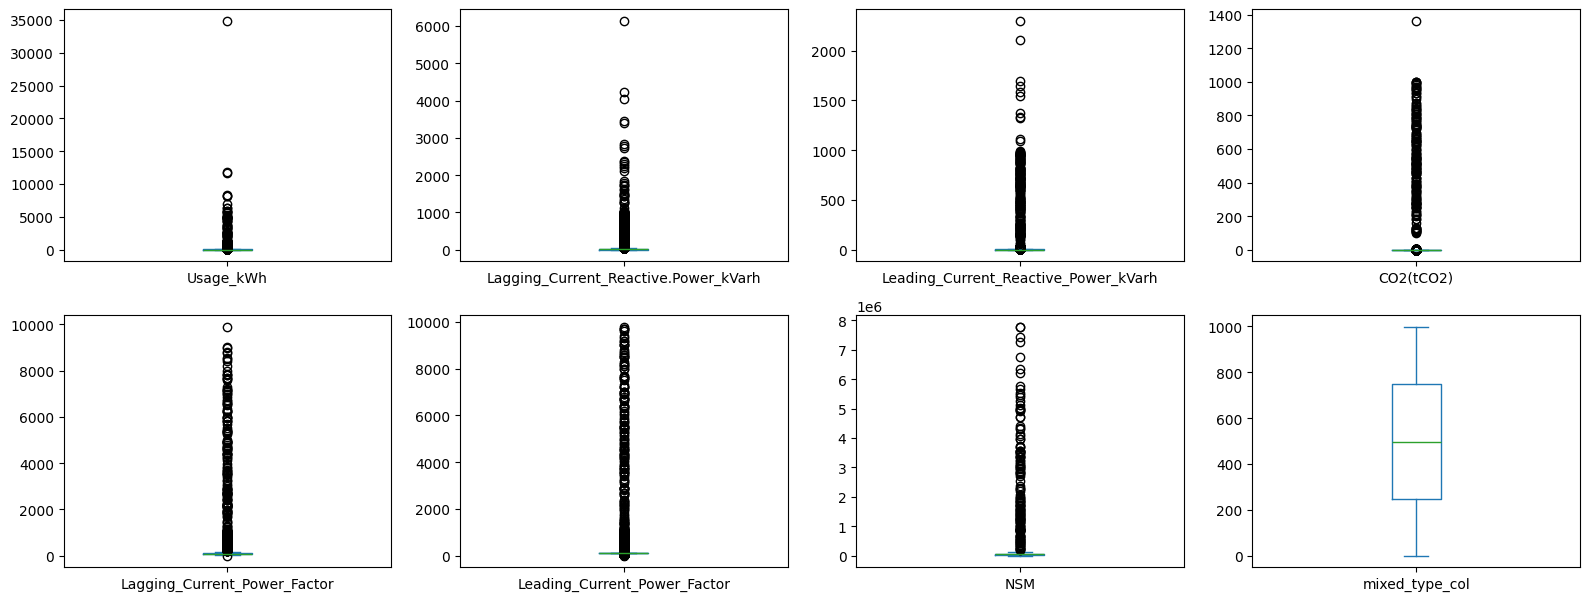

In [17]:
# Boxplots para detectar outliers en variables numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
print(num_cols)
df[num_cols].plot(kind='box', subplots=True, layout=(4,4), figsize=(16,12), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

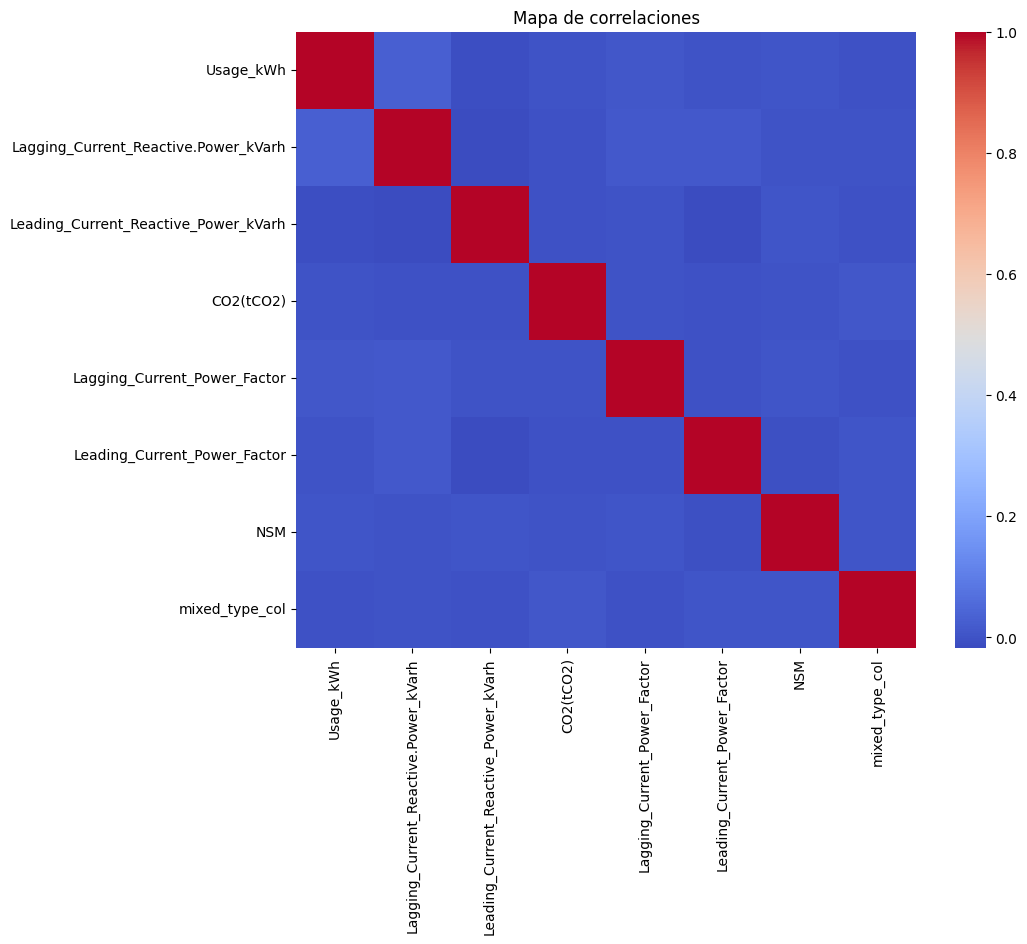

In [18]:
# Correlaciones
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Mapa de correlaciones')
plt.show()

C:\Users\ivan2\AppData\Local\Temp\ipykernel_7584\170853396.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='WeekStatus', palette='pastel')


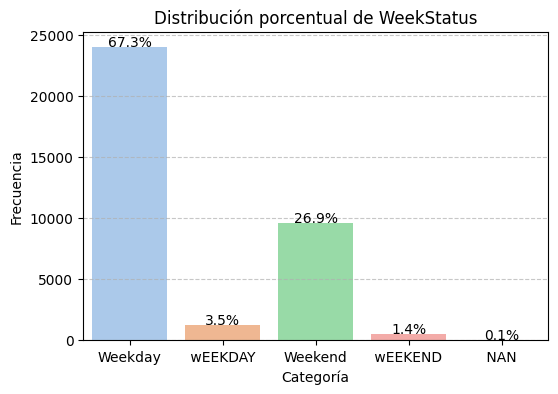

In [19]:
# Distribución de WeekStatus
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='WeekStatus', palette='pastel')

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 50,
            f'{100 * height/total:.1f}%',
            ha='center', fontsize=10)

plt.title('Distribución porcentual de WeekStatus')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\ivan2\AppData\Local\Temp\ipykernel_7584\2853888892.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Day_of_week', palette='pastel')


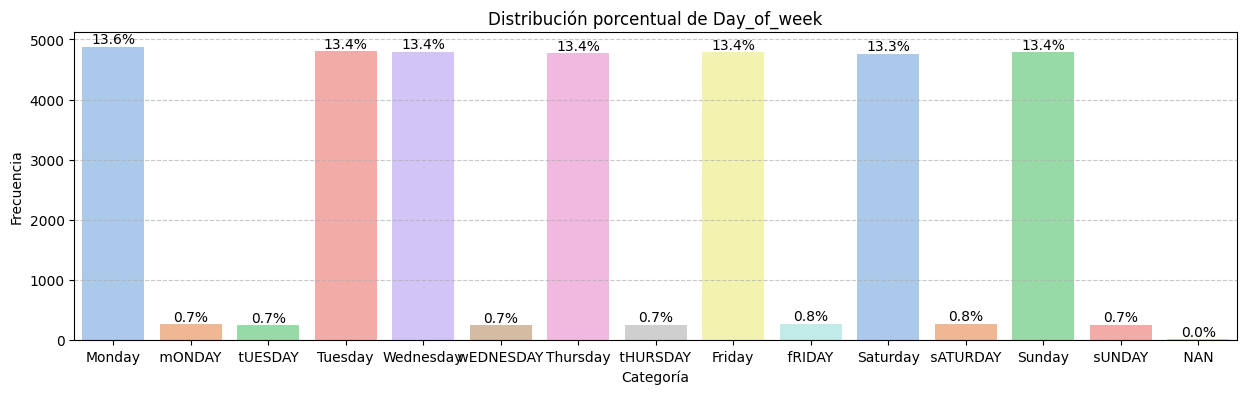

In [20]:
# Distribución de Day_of_week
plt.figure(figsize=(15,4))
ax = sns.countplot(data=df, x='Day_of_week', palette='pastel')

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 50,
            f'{100 * height/total:.1f}%',
            ha='center', fontsize=10)

plt.title('Distribución porcentual de Day_of_week')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\ivan2\AppData\Local\Temp\ipykernel_7584\970924439.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Load_Type', palette='pastel')


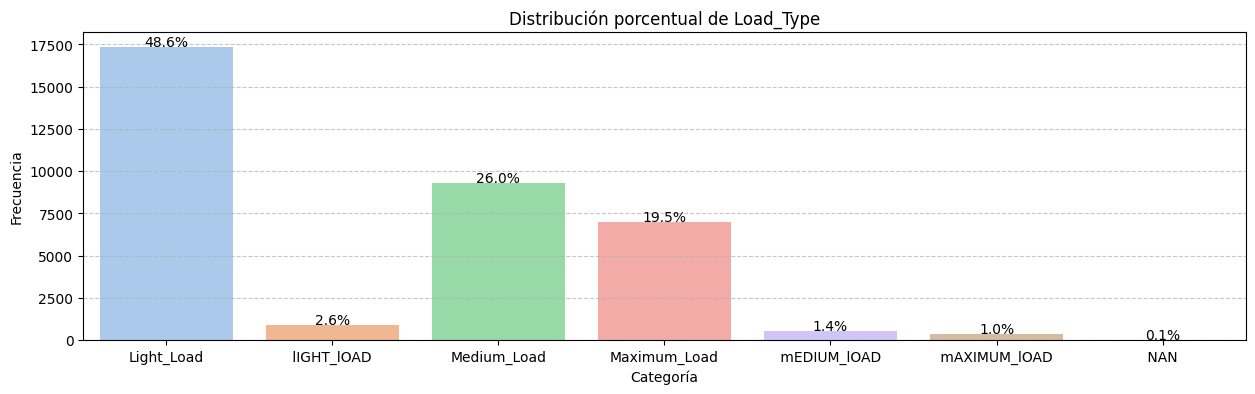

In [21]:
# Distribución de Load_Type
plt.figure(figsize=(15,4))
ax = sns.countplot(data=df, x='Load_Type', palette='pastel')

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 50,
            f'{100 * height/total:.1f}%',
            ha='center', fontsize=10)

plt.title('Distribución porcentual de Load_Type')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Esto s diagramas nos han permitido ver que en las columanas numericas hay outliers muy grandes y que en las categoricas tenemos que corregir los valores ya que presentan diferencias en la escritura.

#### Limpieza de datos

In [22]:
# Eliminar duplicados
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(35740, 12)
(35710, 12)


Imputamos datos vacios o nulos, en el caso de las columnas numericas usamos la media y en el caso de las categoricas usamos la moda. En el caso de las fecha de momento se eliminan aun que creo que lo recomendable seria imputar lor la fecha previa o la siguinete.

In [34]:
def imputar_valores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputa valores nulos en el DataFrame:
      - Para columnas numéricas: reemplaza NaN con la media.
      - Para columnas categóricas/objetos: reemplaza NaN con la moda.

    Retorna un nuevo DataFrame con los valores imputados.
    """

    df_imputado = df.copy()  # evita modificar el original

    # Imputación para columnas numéricas
    num_cols = df_imputado.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df_imputado[col].isna().any():
            mean_value = df_imputado[col].mean()
            df_imputado[col] = df_imputado[col].fillna(mean_value)
            print(f"Columna numérica '{col}': imputada con la media ({mean_value:.3f})")

    # Imputación para columnas categóricas (object / category)
    cat_cols = df_imputado.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        if df_imputado[col].isna().any():
            moda = df_imputado[col].mode(dropna=True)
            if not moda.empty:
                moda_value = moda[0]
                df_imputado[col] = df_imputado[col].fillna(moda_value)
                print(f"Columna categórica '{col}': imputada con la moda ('{moda_value}')")
            else:
                print(f"Columna '{col}' sin moda disponible (todas las filas nulas).")

    # Reporte final
    print("\n🧾 Imputación completada.")
    print(f"Total de valores nulos restantes: {df_imputado.isna().sum().sum()}")

    return df_imputado

In [35]:
# Reemplaza tokens comunes de nulos
df = df.replace(["nan", "NaN", "N/A", "?", "null", "None", ""], np.nan)
# Imputar valores nulos automáticamente
df = imputar_valores(df)

Columna categórica 'WeekStatus': imputada con la moda ('Weekday')
Columna categórica 'Day_of_week': imputada con la moda ('Monday')
Columna categórica 'Load_Type': imputada con la moda ('Light_Load')

🧾 Imputación completada.
Total de valores nulos restantes: 0


In [36]:
# Valores nulos
df.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
mixed_type_col                          0
dtype: int64

In [37]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:15:00,3.17,2.95,0.0,2.638091,73.21,100.0,900.0,Weekday,Monday,Light_Load,649.000000
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.000000,66.77,100.0,1800.0,Weekday,Monday,Light_Load,497.651857
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.000000,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696.000000
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.000000,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630.000000
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.000000,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325.000000


In [38]:
def eliminar_fechas_nulas(df: pd.DataFrame, columna: str = "date") -> pd.DataFrame:
    """
    Elimina filas del DataFrame donde la columna de fecha está vacía o NaT.
    Devuelve un nuevo DataFrame sin modificar el original.
    """
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

    total_inicial = len(df)
    # Elimina filas donde la fecha es NaN o NaT
    df_filtrado = df.dropna(subset=[columna]).copy()
    total_final = len(df_filtrado)

    print(f"Registros eliminados por fecha nula: {total_inicial - total_final}")
    print(f"Registros restantes: {total_final}")

    return df_filtrado

In [39]:
df = eliminar_fechas_nulas(df, columna="date")

Registros eliminados por fecha nula: 0
Registros restantes: 35348


In [40]:
# Valores nulos
df.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
mixed_type_col                          0
dtype: int64

In [41]:
# Mostramos los primero 5 registros
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,2018-01-01 00:15:00,3.17,2.95,0.0,2.638091,73.21,100.0,900.0,Weekday,Monday,Light_Load,649.000000
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.000000,66.77,100.0,1800.0,Weekday,Monday,Light_Load,497.651857
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.000000,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696.000000
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.000000,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630.000000
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.000000,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325.000000


Como vimos en las graficas teniamos valores con el mismo significado pero sintaxis diferente (Light_Load, lIGHT_LOAD, LIGHT_LOAD, Medium_Load, mEDIUM_LOAD, mAXIMUM_LOAD) asi que homologaremos los valores.

In [32]:
def homologar_categorias(df: pd.DataFrame, columnas: list[str], eliminar_nulos: bool = False) -> pd.DataFrame:
    """
    Homologa los valores categóricos dentro de las columnas especificadas:
      - Convierte a minúsculas
      - Elimina espacios, tabs y caracteres especiales innecesarios
      - Capitaliza de forma consistente (ej. 'light_load' → 'Light_Load')
      - Opcionalmente elimina filas con valores nulos

    Parámetros:
    -----------
    df : pd.DataFrame
        El DataFrame original.
    columnas : list[str]
        Nombres de las columnas categóricas a homologar.
    eliminar_nulos : bool
        Si True, elimina filas donde las columnas categóricas estén nulas.

    Retorna:
    --------
    DataFrame con categorías normalizadas.
    """
    df_out = df.copy()

    for col in columnas:
        if col not in df_out.columns:
            print(f"La columna '{col}' no existe, se omite.")
            continue

        print(f"\n🔧 Homologando columna: '{col}'")

        # Convertimos todo a string y limpiamos
        serie = df_out[col].astype("string").str.strip().fillna("nan")

        # Convertimos a minúsculas
        serie = serie.str.lower()

        # Eliminamos espacios adicionales o símbolos raros
        serie = serie.str.replace(r"[^a-z0-9_/ ]", "", regex=True)
        serie = serie.str.replace(r"\s+", "_", regex=True)

        # Capitalizamos consistentemente (primer letra de cada palabra)
        serie = serie.apply(
            lambda x: "_".join([p.capitalize() for p in x.split("_")]) if isinstance(x, str) else x
        )

        # Asignamos la columna limpia
        df_out[col] = serie.replace("Nan", np.nan)

        # Mostramos mapeo antes/después
        valores_unicos = df_out[col].dropna().unique().tolist()
        print(f"Valores únicos normalizados ({len(valores_unicos)}): {valores_unicos}")

    # Eliminar filas con valores nulos si se solicita
    if eliminar_nulos:
        antes = len(df_out)
        df_out = df_out.dropna(subset=columnas)
        despues = len(df_out)
        print(f"\nFilas eliminadas con valores nulos: {antes - despues}")

    print("\nHomologación de categorías completada.")
    return df_out

In [33]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
df = homologar_categorias(df, cat_cols)


🔧 Homologando columna: 'WeekStatus'
Valores únicos normalizados (2): ['Weekday', 'Weekend']

🔧 Homologando columna: 'Day_of_week'
Valores únicos normalizados (7): ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

🔧 Homologando columna: 'Load_Type'
Valores únicos normalizados (3): ['Light_Load', 'Medium_Load', 'Maximum_Load']

Homologación de categorías completada.
